In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from astropy.io import fits
from astropy.table import Table
from grizli import model as griz_model
from scipy.interpolate import interp1d
from spec_tools import Get_Sensitivity
import pysynphot as S
import os
from glob import glob
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

In [59]:
class Single_spec(object):
    def __init__(self, beam, gal_id,min_wv = 8000, max_wv = 11500):
        BEAM = griz_model.BeamCutout(fits_file= beam)

        self.spec_2D = BEAM.grism.data['SCI']
        self.contam_2D = BEAM.contam
        self.clean_2D = BEAM.grism.data['SCI'] - BEAM.contam
        self.cutout = BEAM.beam.direct*(BEAM.beam.seg == gal_id)
        
        xspec, yspec, yerr = BEAM.beam.optimal_extract(BEAM.grism.data['SCI'], bin=0, ivar=BEAM.ivar) #data
        swv, sens = [BEAM.beam.lam, BEAM.beam.sensitivity / np.max(BEAM.beam.sensitivity)]
        isens = interp1d(swv, sens)(xspec)
        
        IDX= [U for U in range(len(xspec)) if min_wv < xspec[U] < max_wv]
        self.wv = xspec[IDX]
        self.fl = yspec[IDX] / isens[IDX]
        self.er = yerr[IDX] / isens[IDX]

class Stack_spec(object):
    def __init__(self, gal_id, g102_min = 8700, g102_max = 11300, g141_min = 11100, g141_max = 16450):
        self.gal_id = gal_id
        p_file = glob('../dataframes/phot/*{0}*'.format(gal_id))[0]
        self.phot_db = pd.read_pickle(p_file)
        
        self.g102_list = glob('../beams/*{0}*g102*'.format(gal_id))
        self.g141_list = glob('../beams/*{0}*g141*'.format(gal_id))
        self.g102_wv, self.g102_fl, self.g102_er = self.Stack_1d_beams(self.g102_list,g102_min,g102_max) 
        self.g141_wv, self.g141_fl, self.g141_er = self.Stack_1d_beams(self.g141_list,g141_min,g141_max) 
        
        spec141 = S.ArraySpectrum(self.g141_wv, self.g141_fl, fluxunits='flam')
        obs141 = S.Observation(spec141, S.ObsBandpass('wfc3,ir,f125w'), force='extrap')

        spec102 = S.ArraySpectrum(self.g102_wv, self.g102_fl, fluxunits='flam')
        obs102 = S.Observation(spec102,S.ObsBandpass('wfc3,ir,f098m'),force='extrap')
        
        C141 = self.phot_db.query('filter == "F125W"')['phot'].values[0] / obs141.effstim('flam')
        C102 = self.phot_db.query('filter == "F098M"')['phot'].values[0] / obs102.effstim('flam')
  
        print(self.phot_db.query('filter == "F125W"')['phot'].values[0])
        print(obs141.effstim('flam'))
        print(self.phot_db.query('filter == "F098M"')['phot'].values[0])
        print(obs102.effstim('flam'))
#         self.g102_fl *= C102
#         self.g102_er *= C102
#         self.g141_fl *= C141
#         self.g141_er *= C141
        
#         self.Stack_g102_g141()
        
    def Stack_1d_beams(self, beam_list, min_wv, max_wv):
        spec = Single_spec(beam_list[0], self.gal_id, min_wv = min_wv, max_wv=max_wv)

        stack_wv = spec.wv[1:-1]

        flgrid = np.zeros([len(beam_list), len(stack_wv)])
        errgrid = np.zeros([len(beam_list), len(stack_wv)])

        # Get wv,fl,er for each spectra
        for i in range(len(beam_list)):
            spec = Single_spec(beam_list[i], self.gal_id, min_wv = min_wv, max_wv=max_wv)
            flgrid[i] = interp1d(spec.wv, spec.fl)(stack_wv)
            errgrid[i] = interp1d(spec.wv, spec.er)(stack_wv)
        ################

        flgrid = np.transpose(flgrid)
        errgrid = np.transpose(errgrid)
        weigrid = errgrid ** (-2)
        infmask = np.isinf(weigrid)
        weigrid[infmask] = 0
        ################

        stack, err = np.zeros([2, len(stack_wv)])
        for i in range(len(stack_wv)):
            stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
            err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
        ################


        stack_fl = np.array(stack)
        stack_er = np.array(err)

        return stack_wv, stack_fl, stack_er
    
    def Stack_g102_g141(self):
        
        bounds = [min(self.g141_wv),max(self.g102_wv)]
        del_g102 = self.g102_wv[1] - self.g102_wv[0]
        del_g141 = self.g141_wv[1] - self.g141_wv[0]
        del_mix = (del_g102 + del_g141) / 2
        mix_wv = np.arange(bounds[0],bounds[1],del_mix)    
        stack_wv = np.append(np.append(self.g102_wv[self.g102_wv < bounds[0]],mix_wv),self.g141_wv[self.g141_wv > bounds[1]])

        flgrid = np.zeros([2, len(stack_wv)])
        errgrid = np.zeros([2, len(stack_wv)])

        # Get wv,fl,er for each spectra
        for i in range(len(stack_wv)):
            if min(self.g102_wv) <= stack_wv[i] <= max(self.g102_wv):
                flgrid[0][i] = interp1d(self.g102_wv, self.g102_fl)(stack_wv[i])
                errgrid[0][i] = interp1d(self.g102_wv, self.g102_er)(stack_wv[i])

            if min(self.g141_wv) <= stack_wv[i] <= max(self.g141_wv):
                flgrid[1][i] = interp1d(self.g141_wv, self.g141_fl)(stack_wv[i])
                errgrid[1][i] = interp1d(self.g141_wv, self.g141_er)(stack_wv[i])
        ################

        flgrid = np.transpose(flgrid)
        errgrid = np.transpose(errgrid)
        weigrid = errgrid ** (-2)
        infmask = np.isinf(weigrid)
        weigrid[infmask] = 0
        ################

        stack, err = np.zeros([2, len(stack_wv)])
        for i in range(len(stack_wv)):
            stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
            err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
        ################

        self.stack_wv = stack_wv
        self.stack_fl = np.array(stack)
        self.stack_er = np.array(err)

In [60]:
sp = Stack_spec(41520)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.opt

9.731929783406503e-19
0.8396976757294573
5.13652718992133e-19
0.16178870161899597


In [42]:
###DATA 
phot_db = pd.read_pickle('../dataframes/phot/gs_41520_phot.pkl')
Clam = 3E18 / phot_db['eff_wv'] **2 * 10**((-1.1)/2.5-29)


In [15]:
f105_cat=fits.open('/Volumes/Vince_homedrive/goods_4.4/goodss_v4.4/goodss-F105W-astrodrizzle-v4.4_drz_sci.fits')


In [25]:
conv = f105_cat[0].header['PHOTFLAM']#/f105_cat[0].header['EXPTIME']


In [26]:
conv


3.03865739999999e-20

In [23]:
f105_values = np.loadtxt('/Volumes/Vince_homedrive/goods_4.4/goodss_v4.4/goodss-F105W-astrodrizzle-v4.4_drz_sub.cat',skiprows=32).T


In [24]:
f105_values.T[41519]


array([ 4.15200000e+04,  8.70834500e+03,  1.59305950e+04,  4.51231790e-02,
        5.19106090e-02,  1.78329700e-02, -3.46000000e+01,  3.46000000e+01,
        1.81000000e-01,  3.50000000e+00,  5.06500000e+00,  4.15000000e+00,
        5.31527262e+01, -2.77162509e+01,  6.63675500e-04,  1.19988100e+01,
        1.55382700e+01,  1.86996100e+01,  1.97093800e+01,  2.09141800e+01,
        2.17278600e+01,  2.33865100e+01,  5.11126200e-02,  7.20556800e-02,
        1.03468600e-01,  1.25127800e-01,  1.58632800e-01,  2.11496800e-01,
        3.17818700e-01,  2.35709000e+01,  2.32902000e+01,  2.30891000e+01,
        2.30320000e+01,  2.29676000e+01,  2.29262000e+01,  2.28463000e+01,
        4.60000000e-03,  5.00000000e-03,  6.00000000e-03,  6.90000000e-03,
        8.20000000e-03,  1.06000000e-02,  1.48000000e-02,  2.15849400e+01,
        2.04039300e-01,  2.29333000e+01,  1.03000000e-02,  4.17509900e+02,
        1.25834400e+00,  1.97170000e+01,  3.30000000e-03,  3.75100000e+00,
        3.02000000e+02,  

In [40]:
f105_values[47][41519] * conv



1.268669547208256e-17

In [ ]:
def Mag(band):
    magnitude=25-2.5*np.log10(band)
    return magnitude

In [37]:
spec102 = S.ArraySpectrum(sp.g102_wv, sp.g102_fl, fluxunits='flam')
obs102 = S.Observation(spec102,S.ObsBandpass('wfc3,ir,f105w'),force='extrap')


In [39]:
obs102.efflam()


10783.221095283368

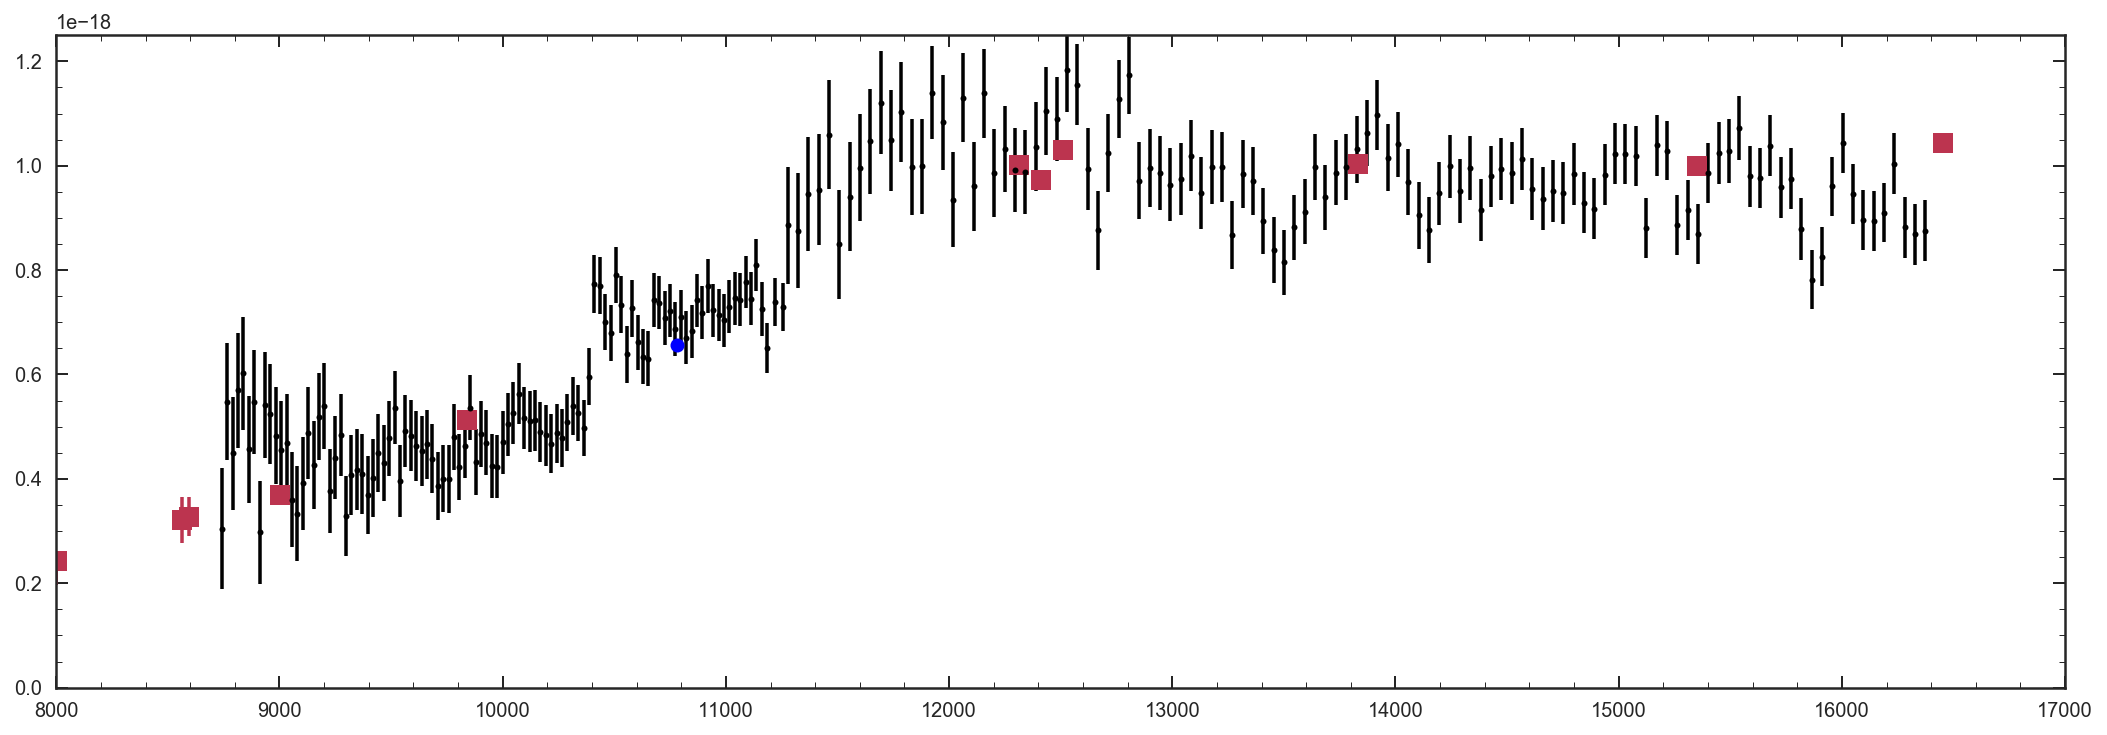

In [49]:
#2.603
plt.figure(figsize=[18,6])
plt.errorbar(sp.g102_wv, sp.g102_fl, sp.g102_er, linestyle='None', marker='o', markersize=3, color='b')

plt.errorbar(sp.g141_wv, sp.g141_fl, sp.g141_er, linestyle='None', marker='o', markersize=3, color='r')
plt.errorbar(phot_db['eff_wv'],phot_db['phot'] ,phot_db['phot_err'],
             color='#BC344F',fmt='s',ms=10,label='Broad-Band Photometry', zorder=2)
# plt.plot(10783.221095283368,f105_values[43][41519] * conv,'bo' )
# plt.errorbar(sp.stack_wv, sp.stack_fl, sp.stack_er, linestyle='None', marker='o', markersize=3, color='k')
# plt.axvline(3934.777,linestyle='--', alpha=.3)
# plt.axvline(3969.588,linestyle='--', alpha=.3)
# plt.axvline(4102.89,linestyle='--', alpha=.3)
# plt.axvline(4305.61,linestyle='--', alpha=.3)
# plt.axvline(4341.68,linestyle='--', alpha=.3)
# plt.axvline(4862.68,linestyle='--', alpha=.3)
# plt.axvline(5176.7,linestyle='--', alpha=.3)
# plt.axvline(5895.6,linestyle='--', alpha=.3)

# plt.axvspan(3910, 3980, color='k', alpha=.1)
# plt.axvspan(3980, 4030, color='k', alpha=.1)
# plt.axvspan(4080, 4120, color='k', alpha=.1)
# plt.axvspan(4250, 4380, color='k', alpha=.1)
# plt.axvspan(4810, 4910, color='k', alpha=.1)
# plt.axvspan(5120, 5240, color='k', alpha=.1)
# plt.axvspan(5810, 5950, color='k', alpha=.1)

plt.xlim(8000,17000)
plt.ylim(0,1.25E-18)
plt.savefig('GS41520_combspec.png')

# g102 and g141 stack test

<ErrorbarContainer object of 3 artists>

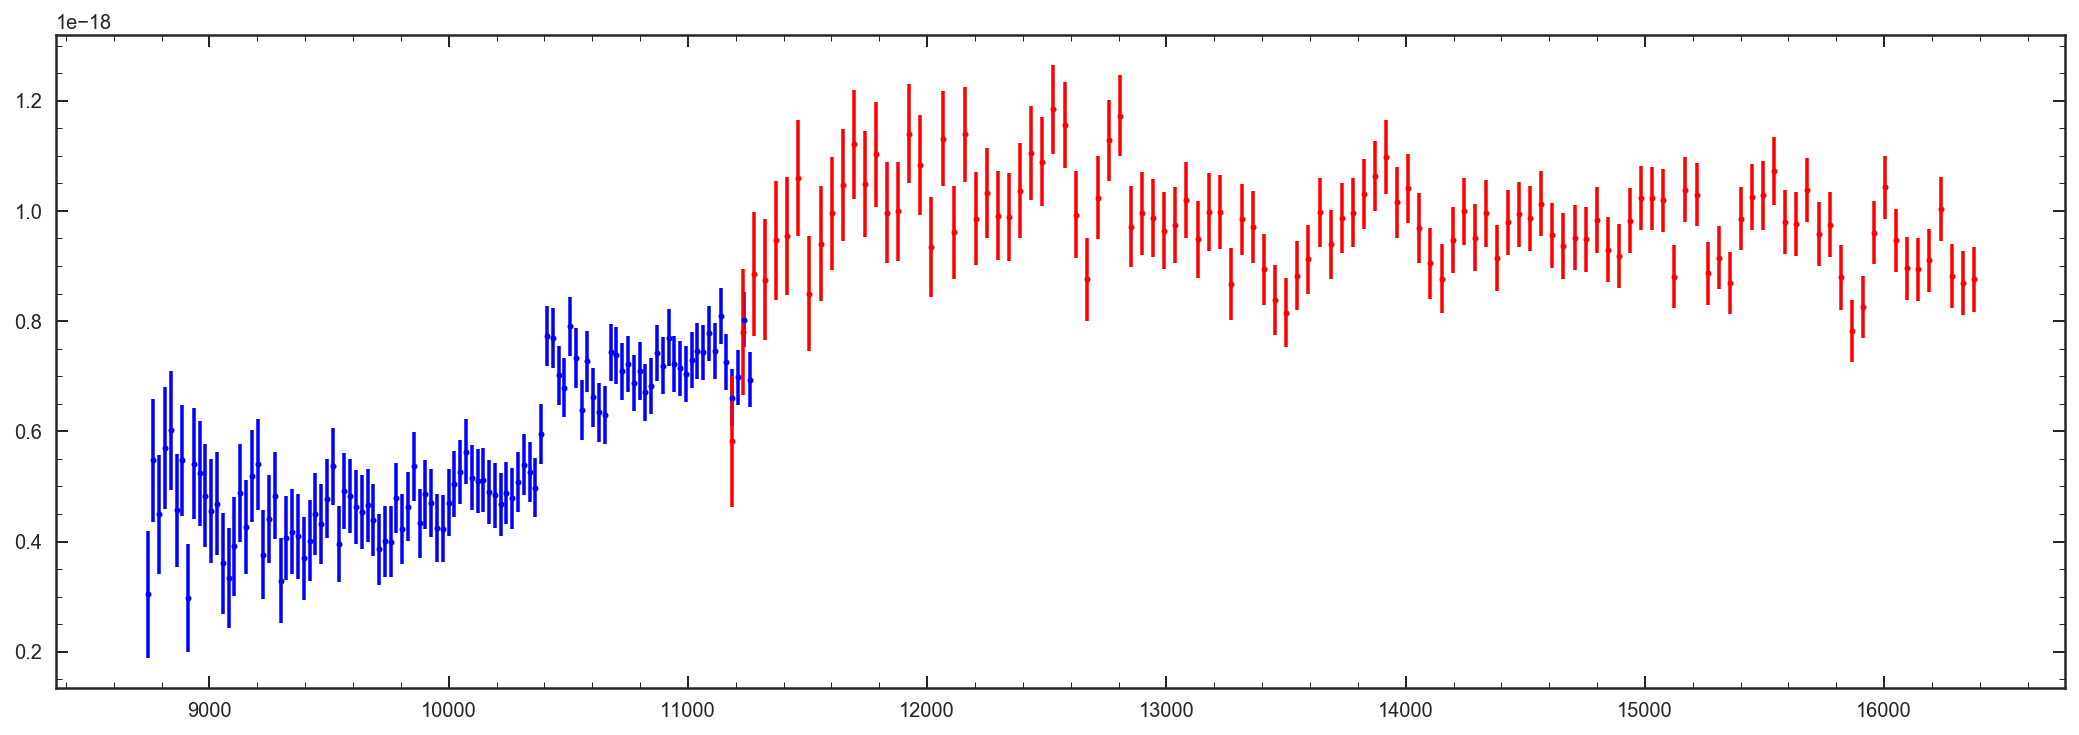

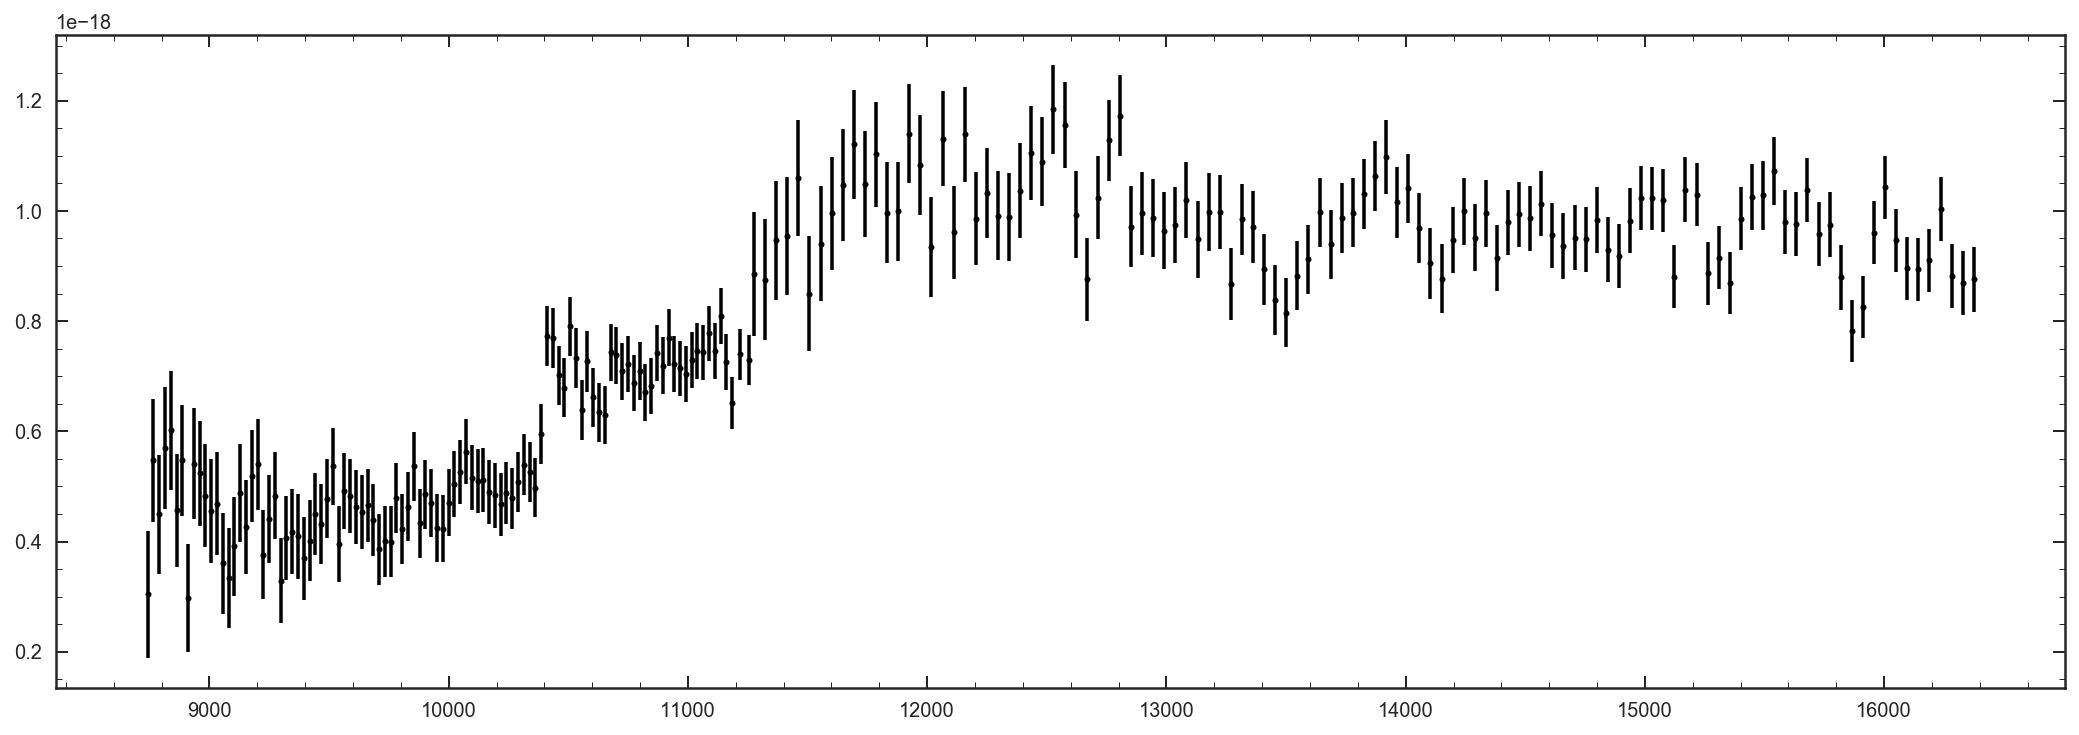

In [256]:
plt.figure(figsize=[18,6])
plt.errorbar(sp.g102_wv, sp.g102_fl, sp.g102_er, linestyle='None', marker='o', markersize=3, color='b')
plt.errorbar(sp.g141_wv, sp.g141_fl, sp.g141_er, linestyle='None', marker='o', markersize=3, color='r')

plt.figure(figsize=[18,6])
plt.errorbar(sp.stack_wv, sp.stack_fl, sp.stack_er, linestyle='None', marker='o', markersize=3, color='k')

In [238]:
bounds = [min(sp.g141_wv),max(sp.g102_wv)]
del_g102 = sp.g102_wv[1] - sp.g102_wv[0]
del_g141 = sp.g141_wv[1] - sp.g141_wv[0]
del_mix = (del_g102 + del_g141) / 2
mix_wv = np.arange(bounds[0],bounds[1],del_mix)

In [240]:
mix_wv

array([11183.74044821, 11219.01011362, 11254.27977903])

In [245]:
new_wv = np.append(np.append(sp.g102_wv[sp.g102_wv < bounds[0]],mix_wv),sp.g141_wv[sp.g141_wv > bounds[1]])

In [249]:
stack_wv = new_wv

flgrid = np.zeros([2, len(stack_wv)])
errgrid = np.zeros([2, len(stack_wv)])

# Get wv,fl,er for each spectra
for i in range(len(stack_wv)):
    if min(sp.g102_wv) <= stack_wv[i] <= max(sp.g102_wv):
        flgrid[0][i] = interp1d(sp.g102_wv, sp.g102_fl)(stack_wv[i])
        errgrid[0][i] = interp1d(sp.g102_wv, sp.g102_er)(stack_wv[i])
        
    if min(sp.g141_wv) <= stack_wv[i] <= max(sp.g141_wv):
        flgrid[1][i] = interp1d(sp.g141_wv, sp.g141_fl)(stack_wv[i])
        errgrid[1][i] = interp1d(sp.g141_wv, sp.g141_er)(stack_wv[i])
################

flgrid = np.transpose(flgrid)
errgrid = np.transpose(errgrid)
weigrid = errgrid ** (-2)
infmask = np.isinf(weigrid)
weigrid[infmask] = 0
################

stack, err = np.zeros([2, len(stack_wv)])
for i in range(len(stack_wv)):
    stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
    err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
################


stack_fl = np.array(stack)
stack_er = np.array(err)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power


In [53]:
dat = pd.read_pickle('../../Quiescent_analysis/data/phot_db.pkl')

In [55]:
dat['s41520']


s_F606Wcand    -99.000000
s_F606W          0.248671
s_R              0.364486
s_Rc             0.393466
s_F775W          1.116272
s_I              2.222116
s_F814Wcand      1.421050
s_F850LP         2.747956
s_F850LPcand   -99.000000
s_F098M          4.566842
s_F105W          6.709343
s_F125W         13.759466
s_J             13.923178
s_tenisJ        14.809924
s_F140W         17.612358
s_H             25.914897
s_tenisK        36.137980
s_Ks            37.240845
s_IA624          0.184528
s_IA651          0.199083
s_IA679          0.347020
s_IA709          0.734140
s_IA738          0.571081
s_IA767          1.037600
s_IA797          1.260295
s_IA827          1.396216
s_IA856          2.164208
n_F606W        -99.000000
n_R            -99.000000
n_Rs           -99.000000
n_I            -99.000000
n_F775W        -99.000000
n_Z            -99.000000
n_F850LP       -99.000000
n_F105W        -99.000000
n_F125W        -99.000000
n_J            -99.000000
n_F140W        -99.000000
n_H         

In [50]:
beams=glob('../beams/*41520*')

In [67]:
indat = fits.open(beams[-1])

In [68]:
print(indat[1].header['PHOTFLAM'])
print(indat[1].header['EXPTIME'])


1
1202.936035


In [69]:
indat[6].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  233                                                  
NAXIS2  =                   52                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
EXTNAME = 'SCI     '           / Extension name                                 
EXTVER  =                    2 / Extension version                              
DATAMIN =          -1.660731E2 / Minimum data value                             
DATAMAX =           6.972043E2 / Maximum data value                             
DATE    = '2012-02-20T18:43:

<ErrorbarContainer object of 3 artists>

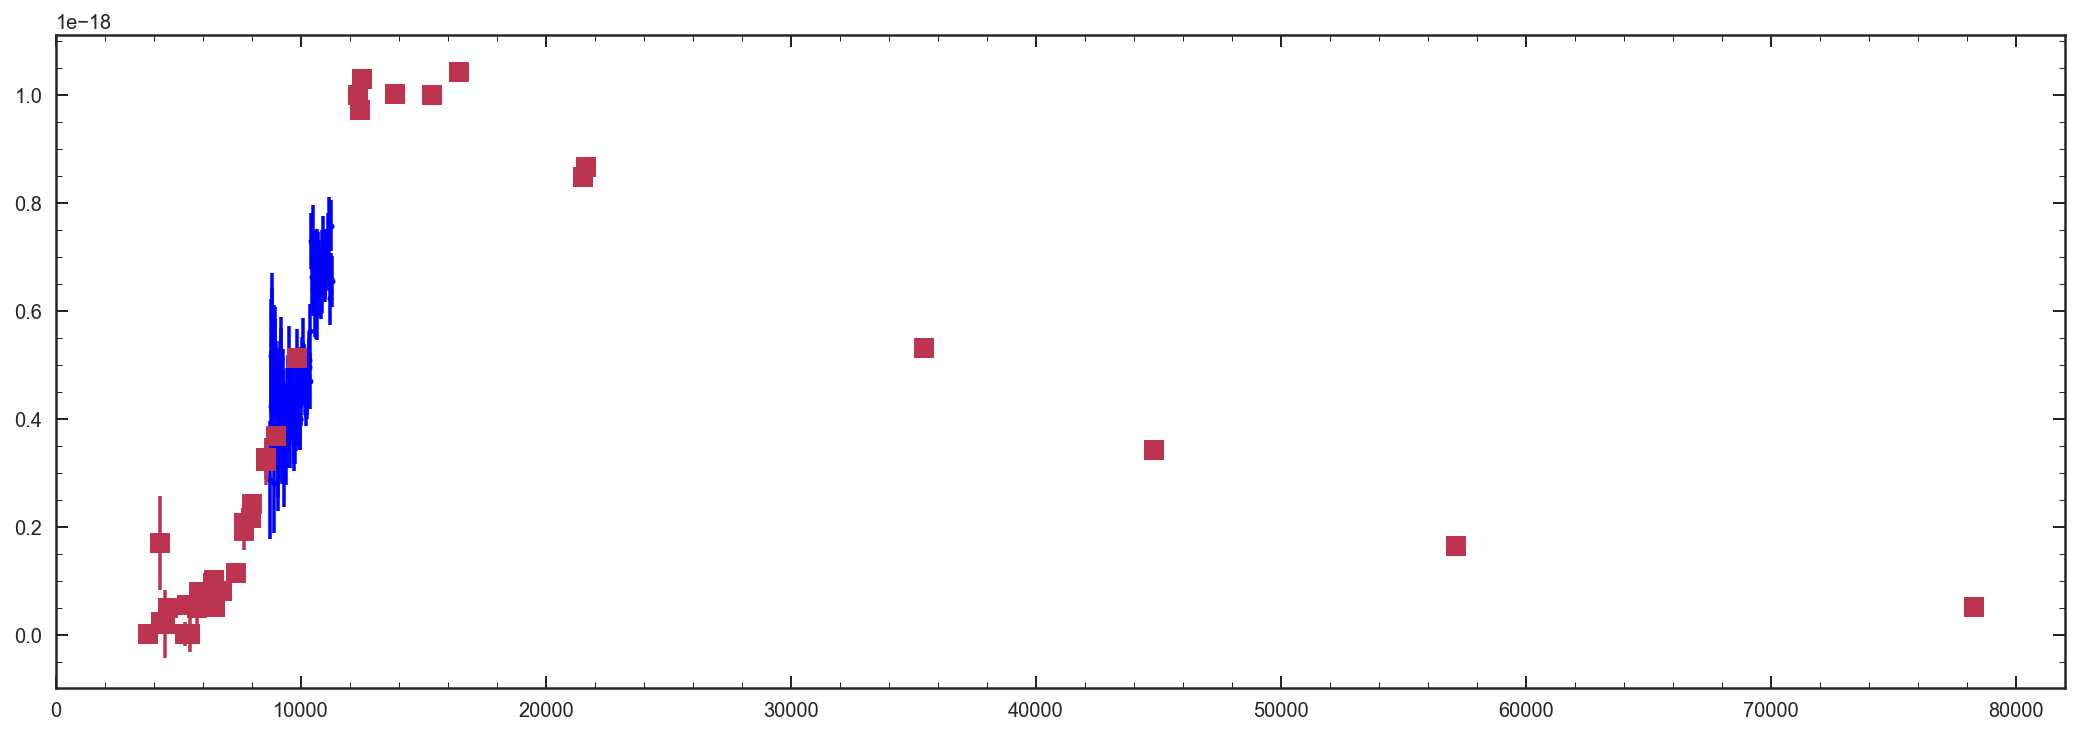

In [66]:
plt.figure(figsize=[18,6])

factor = 3E-18

plt.errorbar(sp.g102_wv, sp.g102_fl*factor, sp.g102_er*factor, linestyle='None', marker='o', markersize=3, color='b')

# plt.errorbar(sp.g141_wv, sp.g141_fl, sp.g141_er, linestyle='None', marker='o', markersize=3, color='r')
plt.errorbar(phot_db['eff_wv'],phot_db['phot'] ,phot_db['phot_err'],
             color='#BC344F',fmt='s',ms=10,label='Broad-Band Photometry', zorder=2)